# ML Classifers (4 or more)
### Project Title - An AI Perspective on the Cryptocurrency Market: Predicting Pump-and-Dump Schemes
### Team Members - Cyrena Burke and Daniel Olaes

In [21]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
import pickle

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "modeling"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Unsupervised Modeling
Our initial cryptocurrency market data does not contain a target label that identifies the kind of market activity that an instance is exhibiting. Therefore, unsupervised learning models may provide good observations on classification of intentional market manipulation.
### ML Techniques used:
- K-Means Clustering & Mini-Batch K-Means Clustering
- Hierachical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)

## Import Processed Data and Drop Time Identifier

In [22]:
CRYPTO_FILE = "processed_crypto_data.csv"
CRYPTO_PATH = os.path.join(".", CRYPTO_FILE)
crypto_data = pd.read_csv(CRYPTO_PATH)
crypto_data = crypto_data.drop(["Unix Timestamp"], axis=1)
crypto_data.head()

,Volume Currency,Volume USD,Price Range
0,293.24,258092.72,9.95000
1,6185590.00,78674.57,0.00057
2,308.89,2309992.42,35.93000
3,184.91,1733771.37,110.04000
4,126.07,109158.24,5.54000


## Split Data into Training and Testing Sets and Scaling
For the K-Means Clustering, the dataset is split into a training and testing set using an 80/20 split and normalized.
Because sklearn HDBSCAN utilizes the whole dataset and does not allow for predict(), the cryto_data set is normalized for use.

Without the **Symbol** feature and with the large numerical ranges between the different cryptocurrencies, we want to normalize the numerical features to ensure that the model does not get influenced by larger numbers during training.

Therefore, we will use Z-score normalization in order to standardization the numerical values to have a mean of 0 and a standard deviation of 1. This places the values in a more manageable range while maintaining the variation.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and testing sets (80% train, 20% test) from K-Means Clustering
X_train, X_test = train_test_split(crypto_data, test_size=0.2, random_state=42)

# Select features to scale
features_to_scale = ["Price Range", "Volume Currency", "Volume USD"]

# Fit scaler to the training set
scaler = StandardScaler()
scaler.fit(X_train[features_to_scale])

# Scale training and testing set
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.transform(X_train[features_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Scale entire dataset separately for unsupervised clustering or visualization
crypto_data_scaled = crypto_data.copy()
crypto_data_scaled[features_to_scale] = scaler.transform(crypto_data[features_to_scale])

Saving figure final_normalized_descriptive_features_scatter_plots


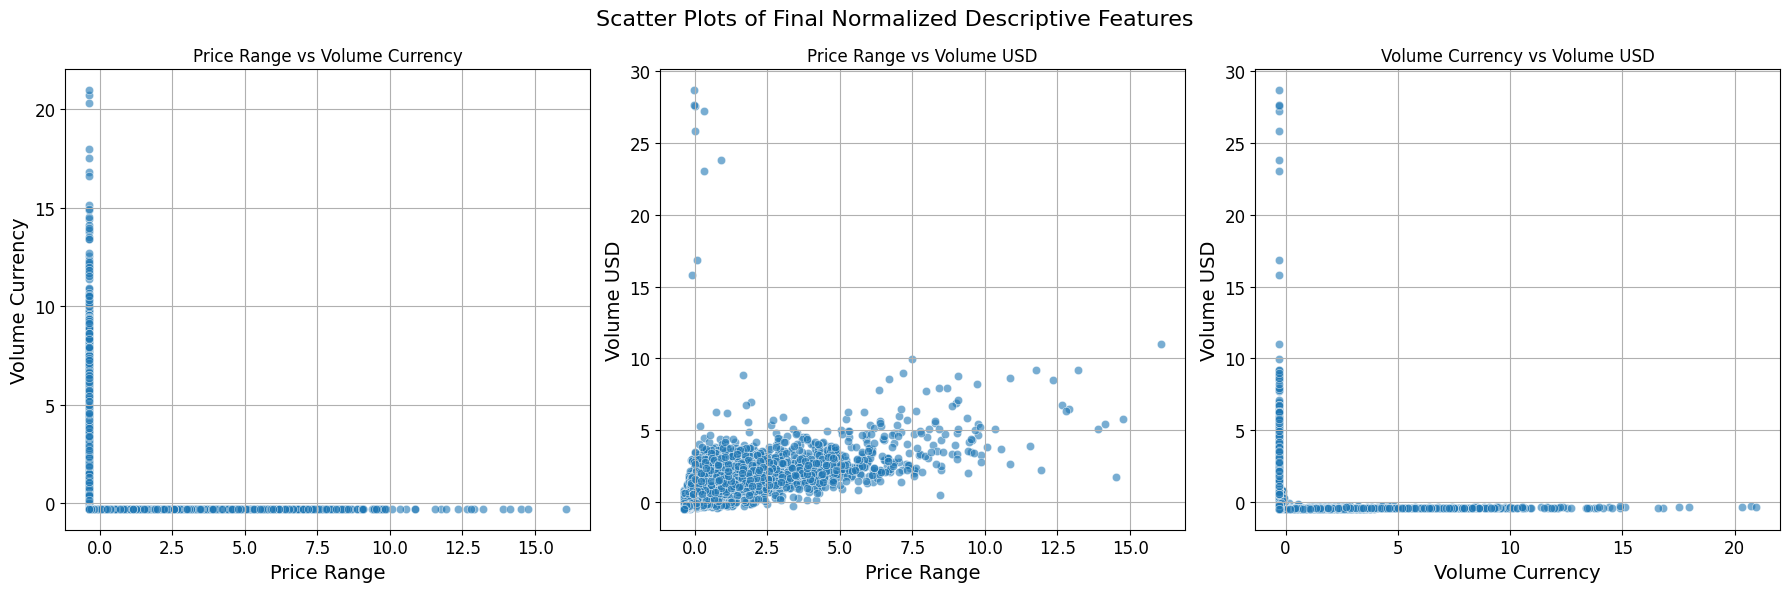

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the original column names from `crypto_data`
columns = crypto_data.columns

# Convert the scaled array back into a DataFrame
crypto_df_scaled = pd.DataFrame(crypto_data_scaled, columns=columns)

# Define feature pairs
feature_pairs = [
    ("Price Range", "Volume Currency"),
    ("Price Range", "Volume USD"),
    ("Volume Currency", "Volume USD")
]

# Create scatter plots
plt.figure(figsize=(18, 6))

for i, (x, y) in enumerate(feature_pairs, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=crypto_data_scaled, x=x, y=y, alpha=0.6)
    plt.title(f"{x} vs {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)

plt.suptitle("Scatter Plots of Final Normalized Descriptive Features", fontsize=16)
save_fig("final_normalized_descriptive_features_scatter_plots") 
plt.show()

## K-Means Clustering
As one of the more simplistic clustering models, we wanted to test it's ability to identify the more abnormal clusters (pump-and-dump market manipulation)

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
try:
    # Fit the model on training set
    kmeans_model = KMeans(n_clusters=3, random_state=42)
    kmeans_model.fit(X_train_scaled)
    # Save the model to disk
    filename = 'finalized_model_M3.sav'
    pickle.dump(kmeans_model, open(filename, 'wb'))
    # Load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    predictions = loaded_model.predict(X_test_scaled)
    result = silhouette_score(X_test_scaled, predictions)
    print(result)
except Exception as e:
    print("Error with K Means Clustering:", str(e))

0.6727410781016898


## Mini-Batch K-Means Clustering

In [26]:
from sklearn.cluster import MiniBatchKMeans
try:
    # Fit the model on training set
    mini_kmeans_model = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=1000)
    mini_kmeans_model.fit(X_train_scaled)
    # Save the model to disk
    filename = 'finalized_model_M3_MiniBatch.sav'
    pickle.dump(mini_kmeans_model, open(filename, 'wb'))
    # Load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    predictions = loaded_model.predict(X_test_scaled)
    result = silhouette_score(X_test_scaled, predictions)
    print(result)
except Exception as e:
    print("Error with Mini Batch K Means Clustering:", str(e))

0.7436001490897878


## Hierachical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)
Because we want to identify instances of intentional market manipulation, HDBSCAN will be a perfect model as it will separate the outlier instances with low density from the normal market activity with high density.

In [27]:
from sklearn.cluster import HDBSCAN
try:
    # Fit the model on training set
    hdbscan_model = HDBSCAN(min_samples=5, cluster_selection_epsilon=0.5, metric='euclidean')
    hdbscan_model.fit(crypto_data_scaled)
    # Save the model to disk
    filename = 'finalized_model_M4.sav'
    pickle.dump(hdbscan_model, open(filename, 'wb'))
    # Load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    labels = loaded_model.labels_
    result = silhouette_score(crypto_data_scaled, labels)
    print(result)

except Exception as e:
    print("Error with HDBSCAN:", str(e))

0.8539522223350926


# Supervised Modeling
By encoding the instances with a target label according to the behaviors they exhibit, we utilized supervised learning to identify pump-and-dump market manipulation.
### ML Techniques used:
- Logistic Regression
- Naive Bayes with feature selection

In [28]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif

#load data
try:
    df = pd.read_csv("processed_crypto_data.csv")
    # print(df.head())  #check 
except:
    print("couldn't load the csv")
    raise

print("columns:", df.columns[:5])  # just to see if it looks right
print("\nPrice Range stats:\n", df['Price Range'].describe())
print("\nVolume USD stats:\n", df['Volume USD'].describe())

# Create percentile-based labels (top 10% of both price and volume)
price_thresh = df['Price Range'].quantile(0.9)
volume_thresh = df['Volume USD'].quantile(0.9)
df['label'] = ((df['Price Range'] > price_thresh) & (df['Volume USD'] > volume_thresh)).astype(int)

print("\nLabel value counts (0 = normal, 1 = pump-like):")
print(df['label'].value_counts())
df.to_csv("processed_crypto_data_with_labels.csv", index=False)

#time changed to day/night
df['datetime'] = pd.to_datetime(df['Unix Timestamp'], unit='s')
df['hour'] = df['datetime'].dt.hour
# print(df[['Unix Timestamp', 'datetime', 'hour']].head())

def get_day_flag(hour):
    if 7 <= hour < 19:
        return 1
    else:
        return 0

df['day_flag'] = df['hour'].apply(get_day_flag)
# print(df[['hour', 'day_flag']].head())

#features
X = pd.DataFrame()
X['vol_cur'] = df['Volume Currency']
X['vol_usd'] = df['Volume USD']
X['price_range'] = df['Price Range']
X['is_day'] = df['day_flag']
# print(X.describe())

y = df['label']
# print(y.value_counts())

#missing values check
missing = False
for c in X.columns:
    if X[c].isnull().any():
        print("missing in", c)
        missing = True
if y.isnull().any():
    print("missing in label")
    missing = True
if not missing:
    print("no missing labels")

# splitting data for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# print("train size:", len(X_train), "test size:", len(X_test))

#full model - logistic
try:
    m1 = LogisticRegression(max_iter=1000)
    m1.fit(X_train, y_train)
    # print("coefficients:", m1.coef_)
    f1 = 'finalized_model_M1.sav'
    pickle.dump(m1, open(f1, 'wb'))
    reload1 = pickle.load(open(f1, 'rb'))
    score1 = reload1.score(X_test, y_test)
    print(score1)
except:
    print("something broke with logistic")

#reduce features - Naive Bayes
try:
    k_best = SelectKBest(score_func=f_classif, k=3)
    fitted = k_best.fit(X, y)
    support = fitted.get_support()
    columns = list(X.columns)
    manually_picked = []
    i = 0
    while i < len(support):
        if support[i] == True:
            manually_picked.append(columns[i])
        i += 1

    print("kept features:", manually_picked)
    # print(fitted.scores_)

    X_train_small = X_train[manually_picked]
    X_test_small = X_test[manually_picked]
    # print(X_train_small.head())

    m2 = GaussianNB()
    m2.fit(X_train_small, y_train)
    f2 = 'finalized_model_M2.sav'
    pickle.dump(m2, open(f2, 'wb'))
    reload2 = pickle.load(open(f2, 'rb'))
    score2 = reload2.score(X_test_small, y_test)
    print(score2)
except:
    print("something went wrong with reduced model")

columns: Index(['Unix Timestamp', 'Volume Currency', 'Volume USD', 'Price Range'], dtype='object')

Price Range stats:
 count    27858.000000
mean        37.653107
std        105.824708
min          0.000000
25%          0.000950
50%          0.011300
75%         14.417500
max       1743.490000
Name: Price Range, dtype: float64

Volume USD stats:
 count    2.785800e+04
mean     6.205030e+05
std      1.322208e+06
min      7.008000e-02
25%      7.395733e+03
50%      4.064595e+04
75%      4.493083e+05
max      3.952536e+07
Name: Volume USD, dtype: float64

Label value counts (0 = normal, 1 = pump-like):
label
0    25851
1     2007
Name: count, dtype: int64
no missing labels
0.9764895908111989
kept features: ['vol_cur', 'vol_usd', 'price_range']
0.7105168700646087
